# 4. CNN Built from Scratch

**Student:** Souhaib Othmani

## Purpose
- Design simple CNN architecture from scratch
- Implement custom CNN model (similar to course examples)
- Train for equal number of epochs as pretrained models
- Compare performance with transfer learning approaches
- Analyze trade-offs between custom and pretrained models

## Architecture Overview

Our custom CNN follows a classic convolutional neural network design:
- **Input**: 224x224x3 RGB images (resized from 28x28 grayscale)
- **Feature Extraction**: 4 convolutional blocks with increasing filters (32 → 64 → 128 → 256)
- **Classification**: Fully connected layers with dropout for regularization
- **Output**: 10 classes (Fashion-MNIST categories)

Imports loaded successfully.
Train shape: (60000, 785)
Test shape: (10000, 785)
Number of classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Image shape (H,W): (28, 28)


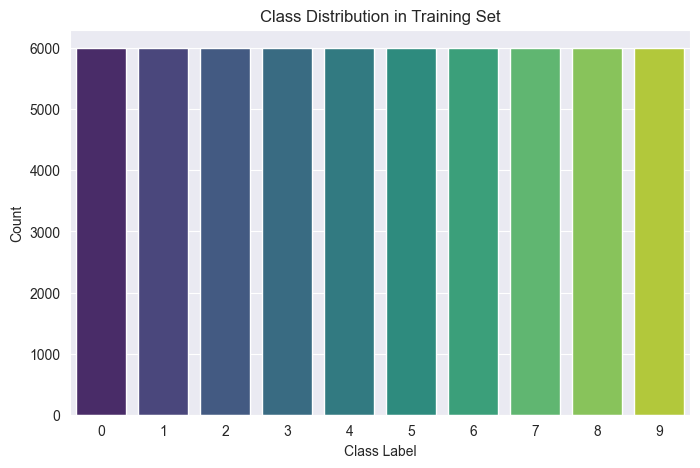

Class counts:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

Is dataset imbalanced? No


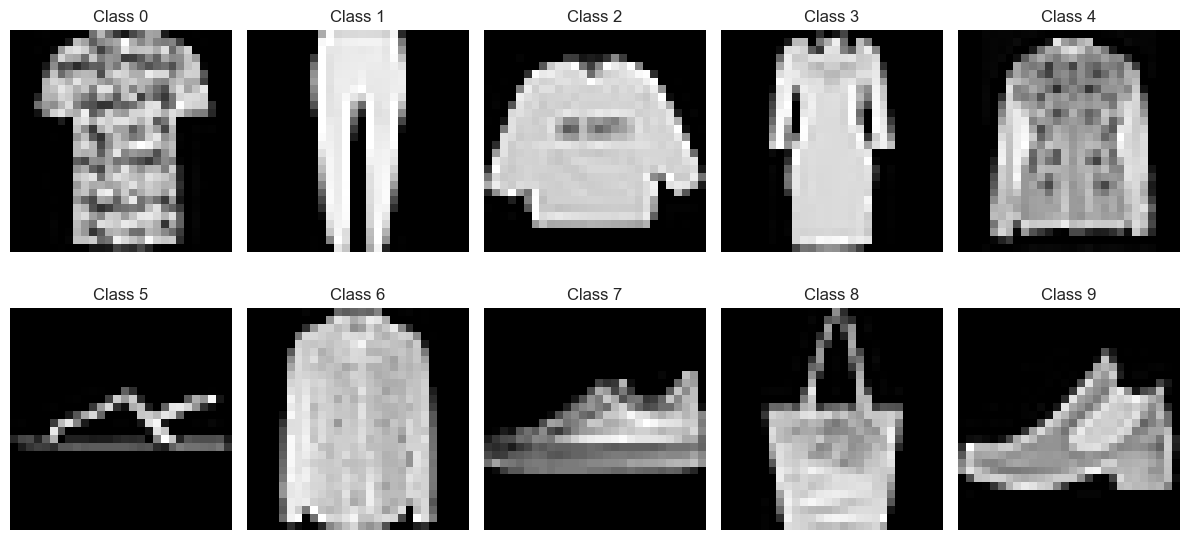

Computing mean/std: 100%|██████████| 60000/60000 [00:01<00:00, 52920.74it/s]


Dataset mean: 0.2861054539680481
Dataset std: 0.35281139612197876
Preprocessing pipeline created successfully.
Train samples: 42000
Validation samples: 9000
Test samples: 9000
Dataloaders created.


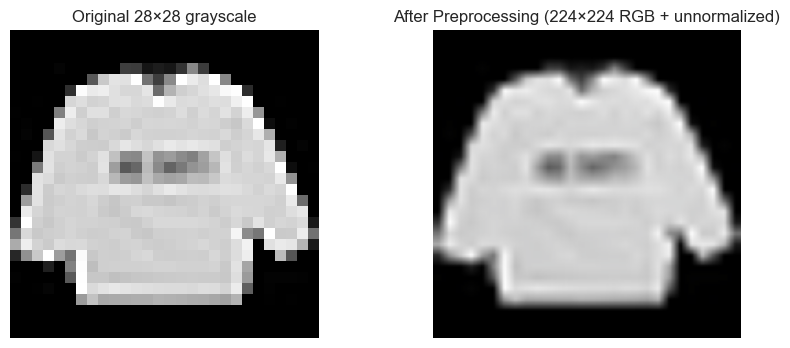

Using device: cpu
Training configuration:
  - Epochs: 10
  - Batch size: 64
  - Learning rate: 0.001


In [1]:
# Import libraries and load setup from previous notebooks
%run ./01_eda_preprocessing.ipynb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import os
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants - SAME as baseline for fair comparison
NUM_CLASSES = 10
NUM_EPOCHS = 10  # Same as pretrained baseline
BATCH_SIZE = 64  # Same as baseline
LEARNING_RATE = 0.001  # Same as baseline

print(f"Training configuration:")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")

## CNN Architecture Design

**Architecture Rationale:**

1. **Convolutional Layers**: We use 4 convolutional blocks with increasing filter counts (32 → 64 → 128 → 256). This progressive increase allows the network to learn increasingly complex features:
   - Early layers: detect edges, textures, simple patterns
   - Later layers: detect higher-level features like shapes and object parts

2. **Batch Normalization**: Added after each convolution to stabilize training and allow higher learning rates.

3. **MaxPooling**: 2x2 pooling after each conv block reduces spatial dimensions by half, creating translation invariance and reducing computation.

4. **Dropout**: Applied in fully connected layers (p=0.5) to prevent overfitting.

5. **Kernel Size**: 3x3 kernels throughout - the standard choice balancing receptive field size and parameter count.

**Input → Output Flow:**
- Input: 224×224×3
- After Conv Block 1: 112×112×32
- After Conv Block 2: 56×56×64
- After Conv Block 3: 28×28×128
- After Conv Block 4: 14×14×256
- After Global Avg Pool: 1×1×256
- Output: 10 classes

In [2]:
# Implement CNN class using nn.Module

class FashionCNN(nn.Module):
    """
    Custom CNN architecture for Fashion-MNIST classification.
    
    Architecture:
    - 4 Convolutional blocks with BatchNorm, ReLU, and MaxPool
    - Global Average Pooling
    - Fully connected classifier with Dropout
    """
    
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()
        
        # Convolutional Block 1: 3 -> 32 channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 224 -> 112
        )
        
        # Convolutional Block 2: 32 -> 64 channels
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112 -> 56
        )
        
        # Convolutional Block 3: 64 -> 128 channels
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56 -> 28
        )
        
        # Convolutional Block 4: 128 -> 256 channels
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 28 -> 14
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )
        
        # Weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using Kaiming (He) initialization for ReLU activations."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x


# Create model instance
model_scratch = FashionCNN(num_classes=NUM_CLASSES).to(device)

# Print model architecture
print("FashionCNN Architecture:")
print("=" * 60)
print(model_scratch)
print("=" * 60)

# Count parameters
total_params = sum(p.numel() for p in model_scratch.parameters())
trainable_params = sum(p.numel() for p in model_scratch.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

FashionCNN Architecture:
FashionCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kern

In [3]:
# Set up training for scratch CNN
# Using SAME optimizer, learning rate, and batch size as baseline

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)

print("Training Setup:")
print(f"  - Optimizer: Adam")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Loss Function: CrossEntropyLoss")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {NUM_EPOCHS}")

Training Setup:
  - Optimizer: Adam
  - Learning Rate: 0.001
  - Loss Function: CrossEntropyLoss
  - Batch Size: 64
  - Epochs: 10


In [4]:
# Initialize TensorBoard logger for scratch CNN

log_dir = "runs/cnn_scratch"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Log hyperparameters
writer.add_text("Hyperparameters", f"lr={LEARNING_RATE}, batch_size={BATCH_SIZE}, epochs={NUM_EPOCHS}")
writer.add_text("Architecture", str(model_scratch))

print(f"TensorBoard logging initialized at: {log_dir}")

TensorBoard logging initialized at: runs/cnn_scratch


In [ ]:
# Train scratch CNN model
# Using identical training loop to pretrained model for fair comparison

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    """Validate model on validation set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return running_loss / total, correct / total


# Training history
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Save directory
save_dir = "./saved_models/cnn_scratch"
os.makedirs(save_dir, exist_ok=True)

print("=" * 60)
print("TRAINING CNN FROM SCRATCH")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch(model_scratch, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_scratch, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Log to TensorBoard
    writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"train": train_acc, "val": val_acc}, epoch)
    
    # Save checkpoint with training history
    checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pt")
    torch.save({
        'model_state_dict': model_scratch.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1,
        'train_losses': train_losses.copy(),
        'val_losses': val_losses.copy(),
        'train_accs': train_accs.copy(),
        'val_accs': val_accs.copy(),
    }, checkpoint_path)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)

Testing: 100%|██████████| 141/141 [01:37<00:00,  1.45it/s]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TEST SET EVALUATION - CNN FROM SCRATCH
Test Accuracy: 0.4220
Precision: 0.4386
Recall: 0.4220
F1-Score: 0.2923

Confusion Matrix:
[[838   0  30   0   0   0   2   0  28   2]
 [  9 151 542   0   0   0   2   0 196   0]
 [ 39   0 845   0   0   0   7   0   9   0]
 [735   0  80   0   0   0   7   0  78   0]
 [167   0 661   0   0   0  50   0  22   0]
 [154   0   0   0   0   0   0   0 352 394]
 [357   0 321   0   0   0 193   0  29   0]
 [ 22   0   0   0   0   0   0   2  22 854]
 [  7   0   3   0   0   0   3   0 886   1]
 [  2   0   0   0   0   0   0   0  15 883]]


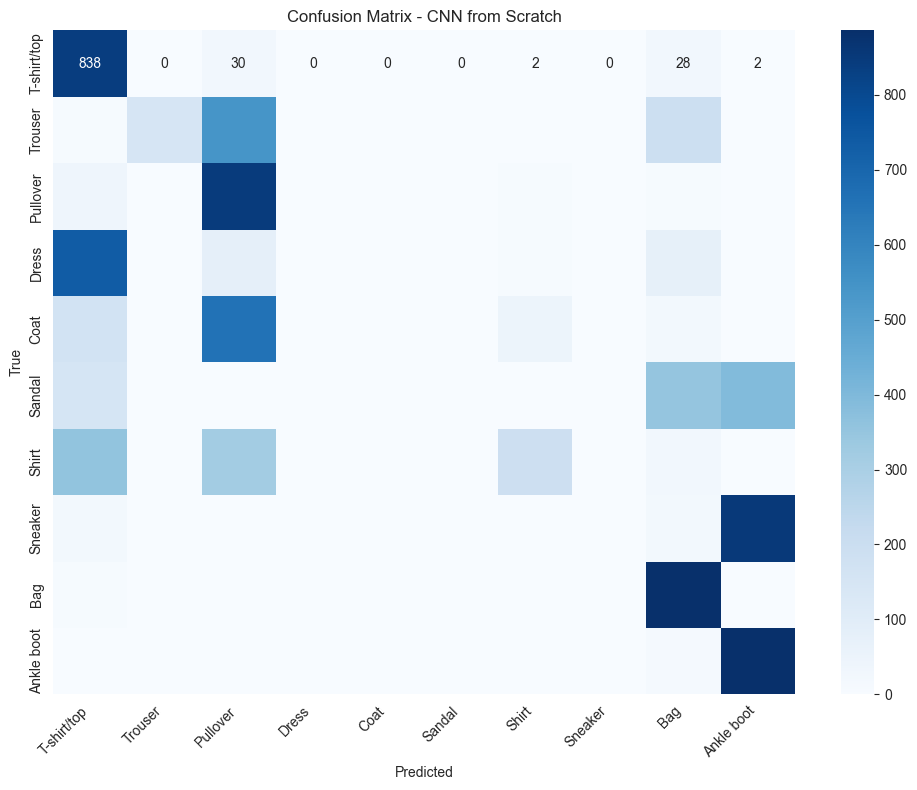

In [6]:
# Evaluate scratch CNN on test set

model_scratch.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_scratch(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
cm = confusion_matrix(all_labels, all_preds)

print("=" * 60)
print("TEST SET EVALUATION - CNN FROM SCRATCH")
print("=" * 60)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Display confusion matrix
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN from Scratch')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./saved_models/cnn_scratch/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

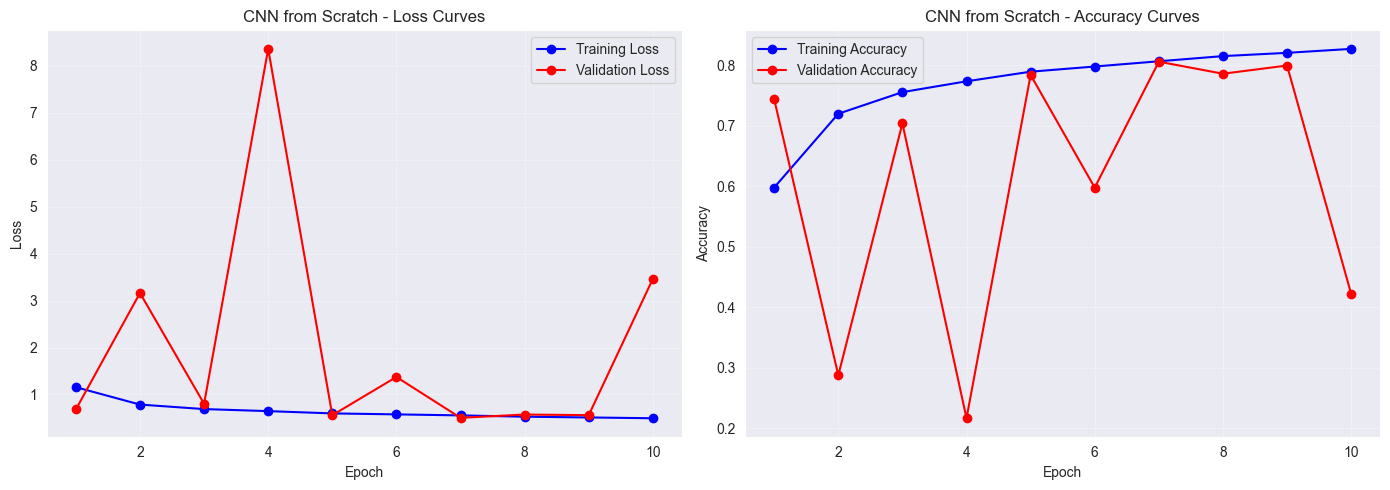


FINAL TRAINING STATISTICS
Final Training Loss: 0.4934
Final Training Accuracy: 0.8272
Final Validation Loss: 3.4615
Final Validation Accuracy: 0.4224
Best Validation Accuracy: 0.8060 (Epoch 7)


In [7]:
# Plot training curves for scratch CNN

epochs_range = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', markersize=6)
ax1.plot(epochs_range, val_losses, 'r-o', label='Validation Loss', markersize=6)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('CNN from Scratch - Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = axes[1]
ax2.plot(epochs_range, train_accs, 'b-o', label='Training Accuracy', markersize=6)
ax2.plot(epochs_range, val_accs, 'r-o', label='Validation Accuracy', markersize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('CNN from Scratch - Accuracy Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./saved_models/cnn_scratch/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final training stats
print("\n" + "=" * 60)
print("FINAL TRAINING STATISTICS")
print("=" * 60)
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")
print(f"Best Validation Accuracy: {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs)) + 1})")

In [ ]:
# Save scratch CNN checkpoint with full training history and test metrics

final_checkpoint = os.path.join(save_dir, "model_checkpoint.pt")
torch.save({
    'model_state_dict': model_scratch.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': NUM_EPOCHS,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'test_accuracy': accuracy,
    'test_precision': precision,
    'test_recall': recall,
    'test_f1': f1,
    'architecture': 'FashionCNN'
}, final_checkpoint)

# Close TensorBoard writer
writer.close()

print("=" * 60)
print("SAVED MODEL CHECKPOINT")
print("=" * 60)
print(f"Checkpoint saved to: {final_checkpoint}")
print(f"\nCheckpoint contains:")
print(f"  - Model weights")
print(f"  - Optimizer state")
print(f"  - Training history (losses and accuracies per epoch)")
print(f"  - Test metrics (accuracy, precision, recall, f1)")

# List all saved files
print(f"\nAll files in {save_dir}/:")
for f in os.listdir(save_dir):
    print(f"  - {f}")

print("\n" + "=" * 60)
print("CNN from Scratch notebook completed successfully!")
print("=" * 60)